<div class="alert alert-block alert-danger">
Note: This notebook uses the python package lightfm which is not supported with Python 3.12!
To run this notebook, use Python 3.11.
</div>

Copyright © 2022 Gurobi Optimization, LLC

# A Music Recommendation System With Mathematical Optimization 

A good song never gets old, except when it does. 
Music streaming services like Spotify periodically provide their millions of users with curated music recommendations to keep them wanting to come back for more. It is important that these recommendations truly resonate with their users, while also introducing them to novelty that keeps their curiosity alive.

In this notebook, we will walk-through how to create a music recommendation system using a mixture of predictive and prescriptive analytics.
The predictive component foresees what users might be into based on their past music preferences, while the prescriptive component uses these predictions to  create an optimally diverse recommendation list.

**Goal**: Recommend new artists to users such that the artists are likeable and diverse.


The datasets used in this notebook are pre-processed from two Kaggle datasets: 
- [Encrypted user data (Pichl, Zangerle and Specht, 2015)](https://www.kaggle.com/datasets/andrewmvd/spotify-playlists) with playlists created by [Spotify](https://open.spotify.com/) users, and 
- [Artist data](https://www.kaggle.com/datasets/pieca111/music-artists-popularity) with musician demographics collected from [Musicbrainz](https://musicbrainz.org/) and [Last.fm](last.fm).

Pichl, Martin; Zangerle, Eva; Specht, Günther: "Towards a Context-Aware Music Recommendation Approach: What is Hidden in the Playlist Name?" in 15th IEEE International Conference on Data Mining Workshops (ICDM 2015), pp. 1360-1365, IEEE, Atlantic City, 2015.

## Load the data

To start, let's load the following packages for analyzing and visualizing the datasets.

In [1]:
%pip install gurobipy seaborn lightfm
import numpy as np 
import pandas as pd 
import warnings 
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt 
import seaborn as sns

We will first load the dataset with artist information. This dataset has 8,465 artists along with information on their  country of origin and the number of listeners they have on [Last.fm](https://www.last.fm/). Each artist is given an id from 0 through 8,465.

In [2]:
df_artist = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/music_recommendation/artist_data.csv')
print(len(df_artist),"artists")
df_artist.head()

8465 artists


,artist_id,artist,country,listeners
0,0,Coldplay,United Kingdom,5381567
1,1,Radiohead,United Kingdom,4732528
2,2,Red Hot Chili Peppers,United States,4620835
3,3,Rihanna,United States,4558193
4,4,Eminem,United States,4517997


Let us take a look at the distribution of the number of listeners for the most popular 2,000 artists.

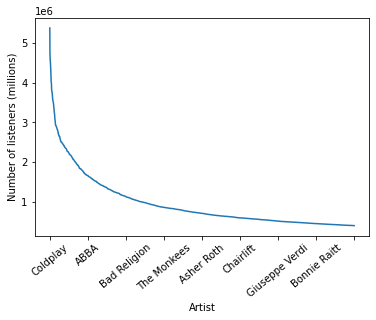

In [3]:
df_artist.set_index('artist')['listeners'].head(2000).plot(rot=40) 
plt.xlabel('Artist')
plt.ylabel('Number of listeners (millions)') 
plt.show()

Where are these artists from? Let us visualize the number of artists from each country. There are 102 countries in this dataset, and the three most common places of origin are: the United States, the United Kingdom and Sweden.

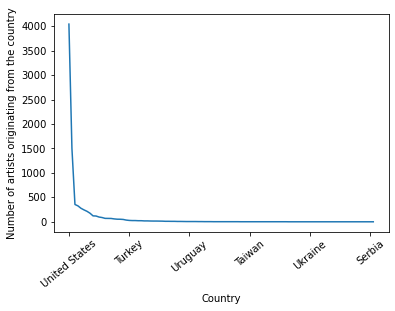

,country,count
0,United States,4041
1,United Kingdom,1500
2,Sweden,355
3,Spain,326
4,Canada,277
...,...,...
97,Saint Vincent and The Grenadines,1
98,Samoa,1
99,Guinea,1
100,Serbia,1


In [4]:
df_country = df_artist.groupby('country')['country'].count().sort_values(ascending = False).reset_index(name="count")
df_country.set_index('country')['count'].plot(rot=40) #Select countries with at least 100 artists from there
plt.xlabel('Country')
plt.ylabel('Number of artists originating from the country') 
plt.show() 
df_country

Next, load the dataset with user information on playlists created by each of the 1,306 users. A playlist is a set of music tracks from various artists. This dataset is important to understand a user's preference over the artists. The number of tracks from an artist that appear in a user's playlist is a good measure of how much a user likes that artist.

In [5]:
df_playlist = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/music_recommendation/user_playlist_data.csv')
print(df_playlist['user_id'].nunique(),"users") 
df_playlist.head(50) 

1306 users


,user_id,artist_id,artist,track,playlist
0,785,622,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,785,622,Elvis Costello,Alison,HARD ROCK 2010
2,785,622,Elvis Costello,Tramp The Dirt Down,HARD ROCK 2010
3,993,622,Elvis Costello,Don't Let Me Be Misunderstood,Everything at once
4,487,622,Elvis Costello,Alison,Home
5,300,622,Elvis Costello,Beautiful,Ángeles
6,155,622,Elvis Costello,Watching The Detectives - Single Version,Vergaarbaak
7,155,622,Elvis Costello,She,Voorbeschouwing
8,317,622,Elvis Costello,Deep Dark Truthful Mirror,We Are Hunted Paramore Chart Jan 12
9,697,622,Elvis Costello,Alison,All Time Great Songs


## Train the prediction model using collaborative filtering

We now train a prediction model to learn the users' preferences of artists using **collaborative filtering**, a popular method commonly used for product recommendations. The idea is to user the collaborative information of all other users to predict the preference of one user.

To achieve collaborative filtering on this user-artist dataset, will use **matrix factorization**. Here, the key input is an $n \times m$ matrix with rows comprising  $n$ users and columns comprising $m$ artists. An entry in the matrix denotes how much that user likes that artist- measured by the frequency of artist occurrence in their playlists. This matrix is factorized into two matrices with dimensions $n \times d$ and $d \times m$, where $d$ is the number of hidden features. The larger the number of features $d$, the more complex and nuanced the model is, albeit running the risk of over-fitting. See [here](https://towardsdatascience.com/intro-to-recommender-system-collaborative-filtering-64a238194a26) to read more about collaborative filtering.


We will use [lightfm](https://github.com/lyst/lightfm) for matrix factorization as follows.

In [6]:
import lightfm 
from lightfm import LightFM, cross_validation
from lightfm.evaluation import auc_score  

Create the input matrix for matrix factorization using the frequency of occurrence of artists in each user's playlists.

In [7]:
# Dataframe that stores the frequency of artists as they appear in users' playlists
df_freq = df_playlist.groupby(['user_id', 'artist']).agg('size').reset_index().rename(columns={0:'freq'})[['user_id', 'artist', 'freq']].sort_values(['freq'], ascending=False)
df_freq = df_freq.merge(df_artist[['artist_id','artist']], left_on='artist', right_on='artist') 

# Input matrix 
input_matrix = df_freq.groupby(['user_id', 'artist_id'])['freq'].sum().unstack().reset_index().fillna(0).set_index('user_id')

# Dictionary to track the artist id for each artist name
artists_dict ={(df_artist.loc[i,'artist_id']): df_artist.loc[i,'artist'] for i in range(df_artist.shape[0])} 
df_freq.head()

,user_id,artist,freq,artist_id
0,701,The Rolling Stones,667,13
1,328,The Rolling Stones,658,13
2,351,The Rolling Stones,93,13
3,469,The Rolling Stones,77,13
4,603,The Rolling Stones,69,13


Before training the prediction model, the dataset is randomly split into a training set (80%) and a testing set (20%) to evaluate the fit. The quality of the fit is measured by the *area under an ROC curve (AUC)* metric. This is a measure of the likelihood that a preferred item by a user is ranked higher than a random item. The closer it is to 1, the better the fit. See [here](https://flowthytensor.medium.com/some-metrics-to-evaluate-recommendation-systems-9e0cf0c8b6cf) to read more about the AUC score.

The parameters for the model are the number of components (or features), the loss function, number of epochs, among others. The values set for these parameters are shown below, but try other values to observe their effect on the performance. 

In [8]:
### Train-Test split
from scipy import sparse
x = sparse.csr_matrix(input_matrix.values)  
train, test = lightfm.cross_validation.random_train_test_split(x, test_percentage=0.2, random_state=None)

### Train the Matrix Factorization Model  
model = LightFM(no_components=50, loss='warp')
model.fit(x, epochs=30, num_threads = 4)
 
train_auc = auc_score(model, train, num_threads=4).mean()  
test_auc = auc_score(model, test, train_interactions=train, num_threads=4).mean()
print('Train AUC: %f, test AUC: %f'%(train_auc,test_auc))

Train AUC: 0.984152, test AUC: 0.985815


## Select a user

The prediction model has been trained. For the rest of the notebook, we focus on recommending artists for one user. First, select a user and retrieve their learned preference scores (a value between 0 and 1) among the artists. The higher the preference score, the greater their preference for that user according to the trained model.

To select a user, use the dropdown at the bottom of this cell to choose a user id from 0 (default) through 1,305.

In [9]:
from __future__ import print_function
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
  
def get_user_preference(x):  
    # Create a dictionary that stores the preference for each artist as a number between 0 and 1
    global preference, df_pref
    preference = pd.Series(model.predict(x, np.arange(input_matrix.shape[1]))).to_dict()
    lower_score = min(preference.values())
    highest_score = max(preference.values())
    preference = {artists_dict[i]:(preference[i]-lower_score)/(highest_score-lower_score) for i in preference}  
     
    # Print the known likes of the user
    known_items = list(pd.Series(input_matrix.loc[x,:][input_matrix.loc[x,:] > 0].index).sort_values(ascending=False))
    known_items = list(pd.Series(known_items).apply(lambda x: artists_dict[x])) 
    print("Top 20 artists this user already likes:\n",known_items[:20]) 
     
    # Print the predicted preference scores of the user
    df_pref = pd.DataFrame.from_records([(k, v) for k, v in preference.items()], columns =['artist', 'preference']) 
    df_pref = df_artist.merge(df_pref,left_on='artist',right_on='artist').sort_values(by = 'preference',ascending=False)
    print("\nPredicted preferences:") 

n_users = df_playlist['user_id'].nunique()
print("Select a user id from 0 through %i."%(n_users-1))
interact(get_user_preference, x=list(range(n_users)))
df_pref.head(30)

Select a user id from 0 through 1305.


interactive(children=(Dropdown(description='x', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

,artist_id,artist,country,listeners,preference
78,78,P!nk,United States,2495211,1.000000
3,3,Rihanna,United States,4558193,0.983621
52,52,Christina Aguilera,United States,2788515,0.963143
66,66,Avril Lavigne,Canada,2627363,0.960885
90,90,Kelly Clarkson,United States,2425837,0.959522
30,30,Britney Spears,United States,3255085,0.921503
62,62,Usher,United States,2650020,0.895425
269,269,Whitney Houston,United States,1607022,0.895255
28,28,The Black Eyed Peas,United States,3346410,0.885004
16,16,Katy Perry,United States,3733134,0.882295


For our chosen user, we have the predicted preference scores for the artists. Looking at the most preferred artists, several of the artists are massively popular. For example, for user 0, their 30 most preferred artists have more than a million listeners on average. 

In [10]:
print("The top 30 artists have %i listeners on average."% int(df_pref[['listeners']].head(30).sum()/30))

The top 30 artists have 2374392 listeners on average.


##  Optimize for popularity diversity


But what if we want to recommend less popular artists? Adding niche artists to the basket of recommended artists could improve the **novelty** of the recommendation, while also supporting newer artists.

We now introduce a mathematical optimization model to optimally resolve this trade-off between preference and popularity. 
An optimization model seeks to find the **best solution** according to an **objective function** such that the solution satisfies a pre-defined set of **constraints**. 
Here, a solution is expressed as a vector of real values or integer (e.g., binary) values called **decision variables**.
Constraints are a set of equations or inequalities written as a function of the decision variables.
 
For our model, a solution is given by the chosen set of artists. The objective function is to maximize the total preference scores among the chosen artists so that the recommended artists are likable. In order to control the overall popularity of the chosen artists, we enforce a constraint that the average popularity is less than a pre-defined maximum limit. We also add a constraint that the number of artists are fixed to a pre-defined value.
Hence, this is an optimization model that maximizes preference with constraints on popularity and size.


Let us now define some input parameters and notations used for creating the model. The subscript $a$ will be used to denote individual artists across the set of all artists we can choose from. The set of artists. preference and popularity are derived from the datasets. 


### Input parameters


$p_a$: the user's preference for an artist $a$,

$q_a$: popularity of artist $a$ measured by their number of listeners,

$N$: number of artists to choose,
  
$P_{max}$: maximum limit on the average popularity among chosen set of artists.

The following code loads the Gurobi python package and initiates the optimization model. The values of $N$ and $P_{max}$ can be altered in the below cell. For illustration, the maximum popularity limit is set to $500,000$ listeners, and the number of artists is set to $30$.

In [11]:
import gurobipy as gp 
from gurobipy import GRB

artists = sorted(preference.keys(),reverse=True,key=lambda x : preference[x])[:1000]  # Set of the most preferred 1000 artists
popularity = df_artist.groupby('artist')['listeners'].apply(float).to_dict() # Popularity of each artist
P_max = 500000
N = 30

m = gp.Model("Recommend artists") # this defines the model that we'll add to as we finish the formulation

Restricted license - for non-production use only - expires 2023-10-25


### Decision variables

The key data structure that stores the solution of an optimization problem is a *decision variable*. In our model, we want to store whether or not an artist is chosen to be included in the solution. Hence, we define the following *binary decision variable* for each artist $a$ to represent a **yes** or **no** decision we want to make. This is modeled as $x_a = 1$  if artist $a$  is chosen; and $x_a = 0$  otherwise.


Dictionaries are a good way to store the decision variables. We can add the variables either by looping through each artist, or all at once (as shown in the commented code below).

In [12]:
x = {}
for a in artists:
    x[a] = m.addVar(vtype=GRB.BINARY)  
# x = m.addVars(artists,vtype=GRB.BINARY)         

### Objective

Next, we will define the objective function: we want to maximize the total preference of the chosen artists.
Using the binary decision variables, the objective can be written as follows.

\begin{align*}
\textrm{maximize} &\sum_{a} p_a x_a
\end{align*}

The following code adds the objective function to the model and tells the model that we want to maximize the function.

In [13]:
m.setObjective(sum(x[a]*preference[a] for a in artists), GRB.MAXIMIZE)
m.ModelSense = GRB.MAXIMIZE

### Popularity constraint

We want to make sure that the average popularity of the chosen artists is less than the pre-defined value $P_{max}$. This condition is expressed as a constraint written as follows.
 
\begin{align*}
\sum_{a} q_a x_a &\leq P_{max}  
\end{align*}

The following code adds this constraint to the model.

In [14]:
popularity_constraints = m.addConstr(sum(x[a]*popularity[a] for a in artists) <= P_max*N)

### Size constraint

Finally, we want to select exactly $N$ number of artists. This condition is expressed as the following constraint.

\begin{align*}
\sum_{a} x_a &= N 
\end{align*}

The following code adds this constraint to the model.

In [15]:
n_artists_constraints = m.addConstr(sum(x[a] for a in artists) == N)

Finally, once all the constraints are added, we can tell Gurobi to solve the optimization model and find the optimal solution.

In [16]:
m.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 1000 columns and 2000 nonzeros
Model fingerprint: 0x5ae73861
Variable types: 0 continuous, 1000 integer (1000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+06]
  Objective range  [6e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+01, 2e+07]
Presolve time: 0.01s
Presolved: 2 rows, 1000 columns, 2000 nonzeros
Variable types: 0 continuous, 1000 integer (1000 binary)
Found heuristic solution: objective 20.9247336

Root relaxation: objective 2.320614e+01, 6 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   23.20614    0    2   20.92473   23.20614  10.9%     -    0s
H    0     0                      23.1567009   23.20614  0.21%   

The optimizer solved the model. Let us now retrieve the optimal solution. The value of variable $x_a$ can be retrieved using the code "x[a].X"; artist $a$ is chosen if x[a].X is $1$.

The following code stores the solution as a Pandas dataframe.

In [17]:
chosen_artists = [a for a in artists if x[a].X > .99]  
dict_artist_country = dict(zip(df_artist.artist, df_artist.country))

df_chosen_artists = pd.DataFrame({'artists':chosen_artists, 'popularity':[popularity[i] for i in chosen_artists], 'preference':[preference[i] for i in chosen_artists], 'country':[dict_artist_country[i] for i in chosen_artists]})
print("Artists chosen:"%(chosen_artists))
df_chosen_artists

Artists chosen:


,artists,popularity,preference,country
0,P!nk,2495211.0,1.000000,United States
1,R. Kelly,1456472.0,0.881024,United States
2,Luther Vandross,700090.0,0.850716,United States
3,Jordin Sparks,902941.0,0.842717,United States
4,Girls Aloud,723845.0,0.835629,United Kingdom
5,Toni Braxton,918419.0,0.822874,United States
6,Brandy,859521.0,0.814069,United States
7,Savage Garden,916122.0,0.807891,Australia
8,Blue,437763.0,0.792209,United Kingdom
9,Shontelle,460620.0,0.785508,Barbados


We can observe that the artists are overall more *niche* than just picking the top 30 preferred artists. While this recommendation is diverse in terms of popularity, the artists are predominantly from a set of few countries. Can international diversity be infused into the recommendation?

## Improving international diversity using constraints

The answer is yes. We now look at adding new constraints that enforce that there should be a pre-determined number of countries represented by the chosen set of artists.  The following is a new input parameter that allows us to set the extent of international diversity.

- $C_{min}$: Minimum number of countries to be represented

Setting $C_{min}$ to be $0$ has no effect on the model, whereas setting it to be $N$ (the number of artists selected) would ensure that all the artists are from $N$ difference countries. The following inputs are first defined.

In [18]:
artists_in_country = df_artist[df_artist['artist'].isin(artists)].groupby('country')['artist'].apply(list).to_dict() # the set of artists from each country
countries = artists_in_country.keys() # The set of all countries
C_min = 20 # A number between 0 and N

### Decision variables

To track whether a country is represented or not, the following binary decision variable is created for each country $c$. This is modeled as $y_c = 1$  if country $c$  is represented; and $y_c = 0$  otherwise. 

The variables are added to the model. Note that we are adding it to the same model that we used earlier.

In [19]:
y = m.addVars(countries, vtype=GRB.BINARY) 

### Constraints relating $y$ and $x$ 

We want to make sure that $y_c$ takes the value $0$ if none of the artists from country $c$ are chosen. 
Hence, we set $y_c$ to be $0$ if the value of $\sum_\limits{\textrm{artists from country $c$}} x_a$ is $0$. This condition can be expressed as the following constraint.

\begin{align*}
y_c  &\leq \sum_{\textrm{artists from country $c$}} x_a \quad  \textrm{for each country}\  c
\end{align*}

We can add these constraints to the model.

In [20]:
country_defining_constraints = m.addConstrs((y[c] <= sum(x[a] for a in artists_in_country[c])) for c in countries)

### International representation constraint

Finally, we want to make sure that $C_{min}$ countries are represented, which can be expressed as the following constraint.  
\begin{align*}
\sum_{c} y_c &\geq C_{min}
\end{align*}

We can add this constraint to the model and initiate the optimization.

In [21]:
country_limit_constraints = m.addConstr(sum(y[c] for c in artists_in_country) >= C_min) 
m.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38 rows, 1035 columns and 3070 nonzeros
Model fingerprint: 0x68609e1d
Variable types: 0 continuous, 1035 integer (1035 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+06]
  Objective range  [6e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 2e+07]

MIP start from previous solve did not produce a new incumbent solution

Presolve removed 14 rows and 14 columns
Presolve time: 0.00s
Presolved: 24 rows, 1021 columns, 3042 nonzeros
Variable types: 0 continuous, 1021 integer (1021 binary)
Found heuristic solution: objective 20.4713302

Root relaxation: objective 2.246906e+01, 53 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   22.46906 

Visualize the solution.

30 artists in 20 countries chosen.
Represented countries: ['Australia', 'Barbados', 'Belgium', 'British Virgin Islands', 'Canada', 'Denmark', 'France', 'Germany', 'Ireland', 'Italy', 'Jamaica', 'Moldova', 'Norway', 'Philippines', 'Romania', 'South Korea', 'Spain', 'Sweden', 'United Kingdom', 'United States']


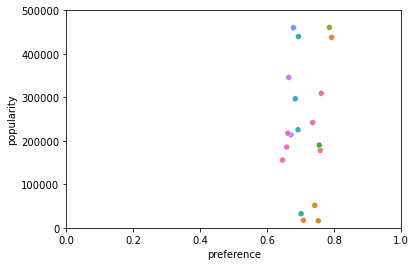

,artists,popularity,preference,country
0,R. Kelly,1456472.0,0.881024,United States
1,Luther Vandross,700090.0,0.850716,United States
2,Céline Dion,1376413.0,0.844627,Canada
3,Jordin Sparks,902941.0,0.842717,United States
4,Girls Aloud,723845.0,0.835629,United Kingdom
5,Enrique Iglesias,1549855.0,0.823422,Spain
6,Brandy,859521.0,0.814069,United States
7,Savage Garden,916122.0,0.807891,Australia
8,Blue,437763.0,0.792209,United Kingdom
9,Shontelle,460620.0,0.785508,Barbados


In [22]:
chosen_artists = [a for a in artists if x[a].X > .99]
chosen_countries = [c for c in artists_in_country if y[c].x > 0.99]
print("%i artists in %i countries chosen."%(len(chosen_artists),len(chosen_countries)))
print("Represented countries:",chosen_countries)

df_chosen_artists = pd.DataFrame({'artists':chosen_artists, 'popularity':[popularity[i] for i in chosen_artists], 'preference':[preference[i] for i in chosen_artists], 'country':[dict_artist_country[i] for i in chosen_artists]})
sns.scatterplot(data=df_chosen_artists, x="preference", y="popularity", hue="country", legend = False)
plt.xlim(0, 1)
plt.ylim(0, 500000)
plt.show()
df_chosen_artists 

We can definitely see more international diversity among the chosen set of artists.

While this notebook walked through how to build an optimization model piece-by-piece, the following code contains the overall optimization model. You can input different parameter values for $P_{max}$ (maximum limit on the average popularity), $N$ (number of chosen artists ) and $C_{min}$ (minimum limit on the number of countries to be represented) and see how the optimal solution changes. The value of $P_{max}$ can be controlled using the slider below the cell.

What happens if $P_{max}$ is too low? Is there a trade-off between popularity and likeability? Can you find a solution where all the artists are uniquely different countries?

In [26]:
def solve(x):
    # Input parameters for artist selection
    P_max = x # maximumum limit on the average popularity
    N = 30 # number of chosen artists 
    C_min = 30 # minimum limit on the number of countries to be represented
    
    #Initiate the model 
    m = gp.Model("Playlisting")  
    
    # Define the variables
    x = m.addVars(artists,vtype=GRB.BINARY) 
    y = m.addVars(countries, vtype=GRB.BINARY) 
    
    # Define the objective 
    m.setObjective(sum(x[a]*preference[a] for a in artists), GRB.MAXIMIZE)
    m.ModelSense = GRB.MAXIMIZE
    
    # Add the constraitns 
    m.addConstr(sum(x[a]*popularity[a] for a in artists) <= P_max*N) # Sets a maximum limit on the average popularity
    m.addConstr(sum(x[a] for a in artists) == N) # Selects exactly N artists 
      
    m.addConstrs((y[c] <= sum(x[a] for a in artists_in_country[c])) for c in countries) # Selects a country only if an artist from that country is chosen
    m.addConstr(sum(y[c] for c in artists_in_country) >= C_min) # Sets a minimum limit on the number of countries represented
    
    m.setParam('OutputFlag', 0) # Suppress the output
    m.optimize() # Run the optimization of the model
    
    if m.status != 2:
        print("\n The problem is infeasible. There is no solution that satisfies all the constraints.")
        print("Try increasing the maximum popularity limit, or decreasing the minimum number of countries to be represented.")
        return
 
    chosen_artists = [a for a in artists if x[a].X > .99] # Chosen set of artists 
    chosen_countries = [c for c in artists_in_country if y[c].x > 0.99] # Chosen set of countries 
    print("%i artists in %i countries chosen."%(len(chosen_artists),len(chosen_countries)))
    print("Represented countries:",chosen_countries)

    # Create a dataframe for the visualization
    df_chosen_artists = pd.DataFrame({'artists':chosen_artists, 'popularity':[popularity[i] for i in chosen_artists], 'preference':[preference[i] for i in chosen_artists], 'country':[dict_artist_country[i] for i in chosen_artists]})
    sns.scatterplot(data=df_chosen_artists, x="preference", y="popularity", hue="country", legend = False)
    plt.xlim(0.6, 1)
    plt.ylim(0, 5000000)
    plt.show()
    print(df_chosen_artists)
     
print("Select a maximum limit on the average popularity:\n")
interact(solve, x=(200000,2000000,200000))

Select a maximum limit on the average popularity:



interactive(children=(IntSlider(value=1000000, description='x', max=2000000, min=200000, step=200000), Output(…

<function __main__.solve(x)>

Copyright © 2022 Gurobi Optimization, LLC